## Ch. 6 rib waveguide 

In [646]:
'''
Module import and define units
'''
import numpy as np
from scipy.sparse import csr_matrix, csc_matrix
from scipy.sparse import diags
from lib.utils import *
from lib.mat_operator import *
from scipy.sparse import hstack, vstack, bmat
import scipy.sparse.linalg as sla
from scipy.sparse.linalg import inv as sinv
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

# units
micrometers = 1
nanometers = micrometers * 1e-3

In [647]:
'''
Dashboard
'''
# wavelength
lam0 = 1.55 * micrometers

# SOI (silicon-on-insulator) rib waveguide parameters
rib_n1 = 1.0
rib_n2 = 3.5
rib_n3 = 1.5
rib_h = 0.60 * micrometers
rib_t = 0.60 * micrometers
rib_w = 0.80 * micrometers

'''
Grid parameters
nmax is needed to determine the smallest wavelength lam_min = lam0 / n_max
RES is No. points required to resolve the shortest wavelength (lam_min)
typical RES values in the range of 10~40
SPACE defiens the space between object an boundaries
the order of values in array is [left, right, above, below]
'''
nmax = max([rib_n1, rib_n2, rib_n3]) 
NRES = 20
SPACER = lam0 * np.array([1.5, 1.5, 0.5, 0.5]) 

# No. modes to be calculated
NMODES = 3

In [648]:

'''
Compute optimized grid
'''
# first guess at grid resolution
dx = (lam0 / nmax) / NRES
dy = (lam0 / nmax) / NRES

# snap grid to critical dimensions
nx = np.ceil(rib_w/dx).astype(int)
dx = rib_w / nx
ny = np.ceil(rib_t/dy).astype(int)
dy = rib_t / ny

# grid size
Sx = SPACER[0] + rib_w + SPACER[1]
Nx = np.ceil(Sx/dx).astype(int)
Sx = Nx * dx

Sy = SPACER[2] + rib_h + rib_t + SPACER[3]
Ny = np.ceil(Sy/dy).astype(int)
Sy = Ny * dy

# 2X grid
Nx2, Ny2, dx2, dy2 = Nx*2, Ny*2, dx/2, dy/2

# grid axes
xa = np.arange(Nx) * dx
xa = xa - xa.mean()
ya = np.arange(Ny) * dy
ya = ya - ya.mean()
xa2 = np.arange(Nx2) * dx2
xa2 = xa2 - xa2.mean()
ya2 = np.arange(Ny2) * dy2
ya2 = ya2 - ya2.mean()

In [649]:
'''
Build device
'''
# initialize to air
ER2 = rib_n1**2 * np.ones((Nx2, Ny2))
UR2 = np.ones((Nx2, Ny2))

# calculate position indices
nx1 = np.round(SPACER[0] / dx2)
nx2 = nx1 + np.round(rib_w/dx2) -1

ny1 = np.round(SPACER[2]/dy2)
ny2 = ny1 + np.round(rib_h/dy2) -1
ny3 = ny2 + 1
ny4 = ny3 + round(rib_t/dy2) - 1
ny5 = ny4 + 1

nx1 = int(nx1)
nx2 = int(nx2)

ny1 = int(ny1)
ny2 = int(ny2)
ny3 = int(ny3)
ny4 = int(ny4)
ny5 = int(ny5)

# build rib waveguide
ER2[nx1 : nx2+1, ny1 : ny2+1] = rib_n2**2
ER2[:, ny3 : ny4+1] = rib_n2**2
ER2[:, ny5 : Ny2+1] = rib_n3**2

In [689]:
# extract materials tensors
ERxx = ER2[1:Nx2+1:2, 0:Ny2+1:2]
ERyy = ER2[0:Nx2+1:2, 1:Ny2+1:2]
ERzz = ER2[0:Nx2+1:2, 0:Ny2+1:2]

URxx = UR2[0:Nx2+1:2, 1:Ny2+1:2]
URyy = UR2[1:Nx2+1:2, 0:Ny2+1:2]
URzz = UR2[1:Nx2+1:2, 1:Ny2+1:2]

'''
Perform finit-difference analysis
# '''
# diagonalize material arrays
ERxx = diags(ERxx.flatten(order='F')).tocsr()
ERyy = diags(ERyy.flatten(order='F')).tocsr()
ERzz = diags(ERzz.flatten(order='F')).tocsr()
URxx = diags(URxx.flatten(order='F')).tocsr()
URyy = diags(URyy.flatten(order='F')).tocsr()
URzz = diags(URzz.flatten(order='F')).tocsr()

# build derivative matrices
k0 = 2 * np.pi / lam0
Ns = (Nx, Ny)
RES = (k0 * dx, k0 * dy)
BCOND = (BC.DBC, BC.DBC)
DEX, DEY, DHX, DHY = yeeder2d(Ns, RES, BCOND)

DEX = DEX.astype(np.double).tocsr()
DEY = DEY.astype(np.double).tocsr()
DHX = DHX.astype(np.double).tocsr()
DHY = DHY.astype(np.double).tocsr()

# build P and Q matrices
P = bmat([[DEX*sinv(ERzz)*DHY, -(DEX*sinv(ERzz)*DHX +  URyy)],
        [DEY*sinv(ERzz)*DHY + URxx, -DEY*sinv(ERzz)*DHX]])
Q = bmat([[DHX*sinv(URzz)*DEY, -(DHX*sinv(URzz)*DEX +  ERyy)],
          [DHY*sinv(URzz)*DEY + ERxx, -DHY*sinv(URzz)*DEX]])
             
# solve Eigenvalue problem
ev = - rib_n2**2

c:\Users\spruce\anaconda3\envs\struct\lib\site-packages\scipy\sparse\_data.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  self._deduped_data().astype(dtype, casting=casting, copy=copy),
c:\Users\spruce\anaconda3\envs\struct\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
c:\Users\spruce\anaconda3\envs\struct\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [797]:
D2, Exy = sla.eigs(A=P*Q, k=NMODES, sigma=ev)
D = diags(np.sqrt(D2)).tocsr()
NEFF = -1j * np.sqrt(D2)

In [874]:
# calculate other field components
M = Nx * Ny
Ex = Exy[:M, :]
Ey = Exy[M:2*M, :]

Hxy = (Q*csr_matrix(Exy))*sinv(D)
Hx = Hxy[:M, :]
Hy = Hxy[M:2*M, :]

Ex = spsolve(ERzz, csr_matrix(DHX*Hy - DHY*Hx)).toarray()
Hz = spsolve(URzz, csr_matrix(DEX*Ey - DEY*Ex)).toarray()

Hx = Hx.toarray()
Hy = Hy.toarray()

c:\Users\spruce\anaconda3\envs\struct\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
c:\Users\spruce\anaconda3\envs\struct\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


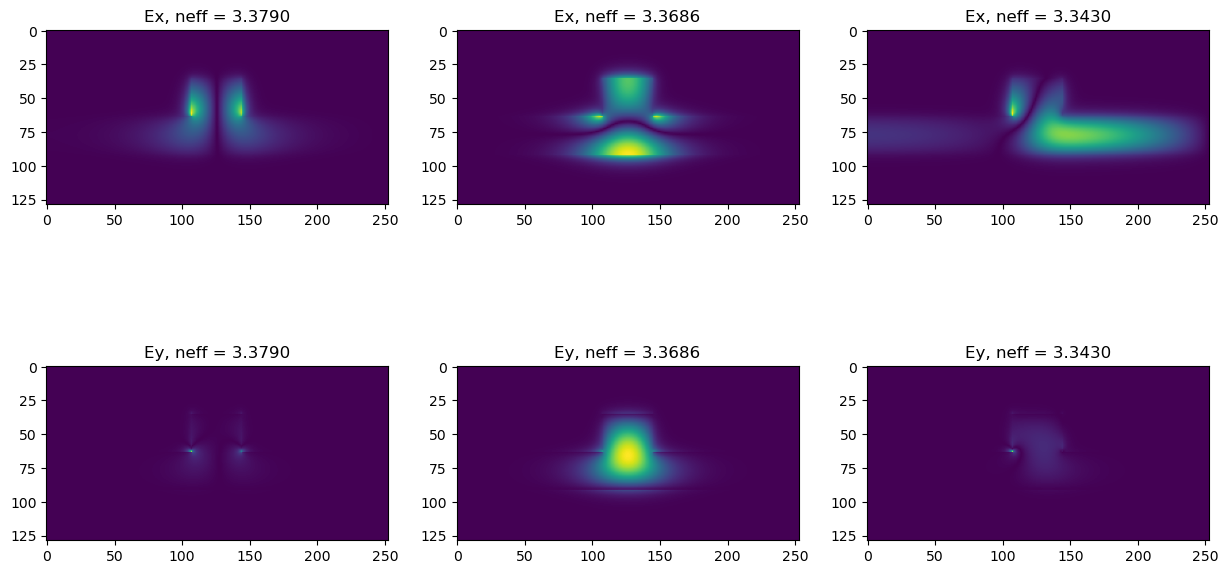

In [883]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = axes.ravel()

for mode in range(NMODES):
    ex = Ex[:, mode].reshape(Nx, Ny, order='F')
    ey = Ey[:, mode].reshape(Nx, Ny, order='F')

    fmax = np.max(np.hstack([np.abs(ex), np.abs(ey)]))

    ex = ex / fmax
    ey = ey / fmax

    ax[mode].set_title(f'Ex, neff = {np.real(NEFF[mode]):.4f}')
    ax[mode].imshow(abs(ex).T)
    
    ax[mode+3].set_title(f'Ey, neff = {np.real(NEFF[mode]):.4f}')
    ax[mode+3].imshow(abs(ey).T)

plt.savefig('./figures/E_mode.png')


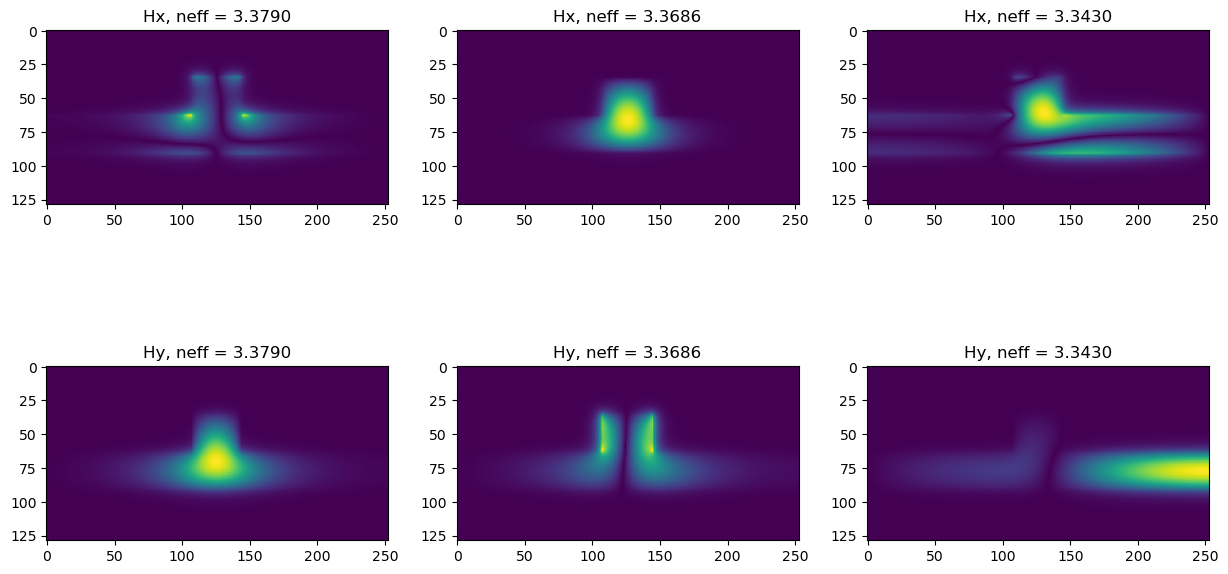

In [884]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = axes.ravel()

for mode in range(NMODES):
    hx = Hx[:, mode].reshape(Nx, Ny, order='F')
    hy = Hy[:, mode].reshape(Nx, Ny, order='F')

    fmax = np.max(np.hstack([np.abs(hx), np.abs(hy)]))

    hx = hx / fmax
    hy = hy / fmax

    ax[mode].set_title(f'Hx, neff = {np.real(NEFF[mode]):.4f}')
    ax[mode].imshow(abs(hx).T)
    
    ax[mode+3].set_title(f'Hy, neff = {np.real(NEFF[mode]):.4f}')
    ax[mode+3].imshow(abs(hy).T)
plt.savefig('./figures/H_mode.png')